In [12]:
from botorch.models.gpytorch import GPyTorchModel
import numpy as np
import matplotlib.pyplot as plt
import torch
from openTSNE import TSNE
from typing import Tuple, Optional

def fetch_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_gp_contours_with_uncertainty(gp_model, d_values, highlight_point=None, title=''):

    # Generate uniform samples in R^4
    num_samples = 1000
    S = np.random.rand(num_samples, 4)

    # Reduce dimensionality of the state space to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    S_reduced = tsne.fit(S)

    # Generate grid for plotting
    x = np.linspace(np.min(S_reduced[:, 0]), np.max(S_reduced[:, 0]), 100)
    y = np.linspace(np.min(S_reduced[:, 1]), np.max(S_reduced[:, 1]), 100)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.ravel(), Y.ravel()]).T

    fig, axes = plt.subplots(2, d_values, figsize=(15, 10))

    for d in range(d_values):
        d_tensor = torch.tensor([d] * xy.shape[0]).view(-1, 1).to(fetch_device())
        xy_tensor = torch.tensor(xy).to(fetch_device())
        input_tensor = torch.cat((xy_tensor, d_tensor), dim=1)

        with torch.no_grad():
            posterior = gp_model.posterior(input_tensor)
            gp_mean = posterior.mean.cpu().numpy()
            gp_var = posterior.variance.cpu().numpy()

        Z_mean = gp_mean.reshape(X.shape)
        Z_std = np.sqrt(gp_var).reshape(X.shape)

        # Mean contour plot
        ax_mean = axes[0, d]
        contour_mean = ax_mean.contourf(X, Y, Z_mean, cmap='viridis', alpha=0.8)
        ax_mean.contour(X, Y, Z_mean, colors='k', linewidths=0.5)
        ax_mean.set_title(f'{title} Mean, a={d}')
        fig.colorbar(contour_mean, ax=ax_mean)
        ax_mean.set_xlabel('s1')
        ax_mean.set_ylabel('s2')

        # Standard deviation contour plot
        ax_std = axes[1, d]
        contour_std = ax_std.contourf(X, Y, Z_std, cmap='viridis', alpha=0.8)
        ax_std.contour(X, Y, Z_std, colors='k', linewidths=0.5)
        ax_std.set_title(f'{title} Std Dev, a={d}')
        fig.colorbar(contour_std, ax=ax_std)
        ax_std.set_xlabel('s1')
        ax_std.set_ylabel('s2')

        # Highlight the specified point if provided
        if highlight_point:
            ax_mean.scatter(highlight_point[0], highlight_point[1], color='red' if d == highlight_point[2] else 'blue',
                            label='Highlight Point')
            ax_std.scatter(highlight_point[0], highlight_point[1], color='red' if d == highlight_point[2] else 'blue',
                           label='Highlight Point')

    plt.show()

In [13]:
from botorch import fit_gpytorch_mll
import numpy as np
import torch
from botorch.models import MixedSingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood

# Step 1: Generate dummy data
def generate_dummy_data(num_samples=50):
    x_continuous = np.random.uniform(0, 1, (num_samples, 4))  # 4-dimensional continuous part
    x_discrete = np.random.randint(0, 3, num_samples).reshape(-1, 1)  # Discrete dimension with values in {0, 1, 2}
    inputs = np.hstack([x_continuous, x_discrete])
    targets = np.sin(2 * np.pi * inputs[:, 0]) + np.cos(2 * np.pi * inputs[:, 1]) + 0.1 * inputs[:, 2] + 0.1 * np.random.randn(num_samples)
    return torch.tensor(inputs, dtype=torch.float64), torch.tensor(targets, dtype=torch.float64).unsqueeze(-1)

train_x, train_y = generate_dummy_data()

# Step 2: Instantiate and train the GP model
categorical_features = [4]  # The index of the discrete dimension
gp_mixed_model = MixedSingleTaskGP(train_X=train_x, train_Y=train_y, cat_dims=categorical_features).to(fetch_device())
mll = ExactMarginalLogLikelihood(gp_mixed_model.likelihood, gp_mixed_model)
fit_gpytorch_mll(mll)

/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0134], dtype=torch.float64), std = tensor([1.0121], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-06)
    )
  )
  (model): MixedSingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-06)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): AdditiveKernel(
      (kernels): ModuleList(
        (0): ScaleKernel(
          (base_kernel): AdditiveKernel(
            (kernels): ModuleList(
              (0): MaternKernel(
                (raw_lengthscale_constraint): GreaterThan(1.000E-04)
              )
              (1): ScaleKernel(
                (base_kernel): CategoricalKernel(
                  (raw_lengthscale_constraint): GreaterThan(1.000E-06)
                )
                (raw_outputscale_constraint): Positive()
              )
            )
         

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 5 but got size 3 for tensor number 1 in the list.

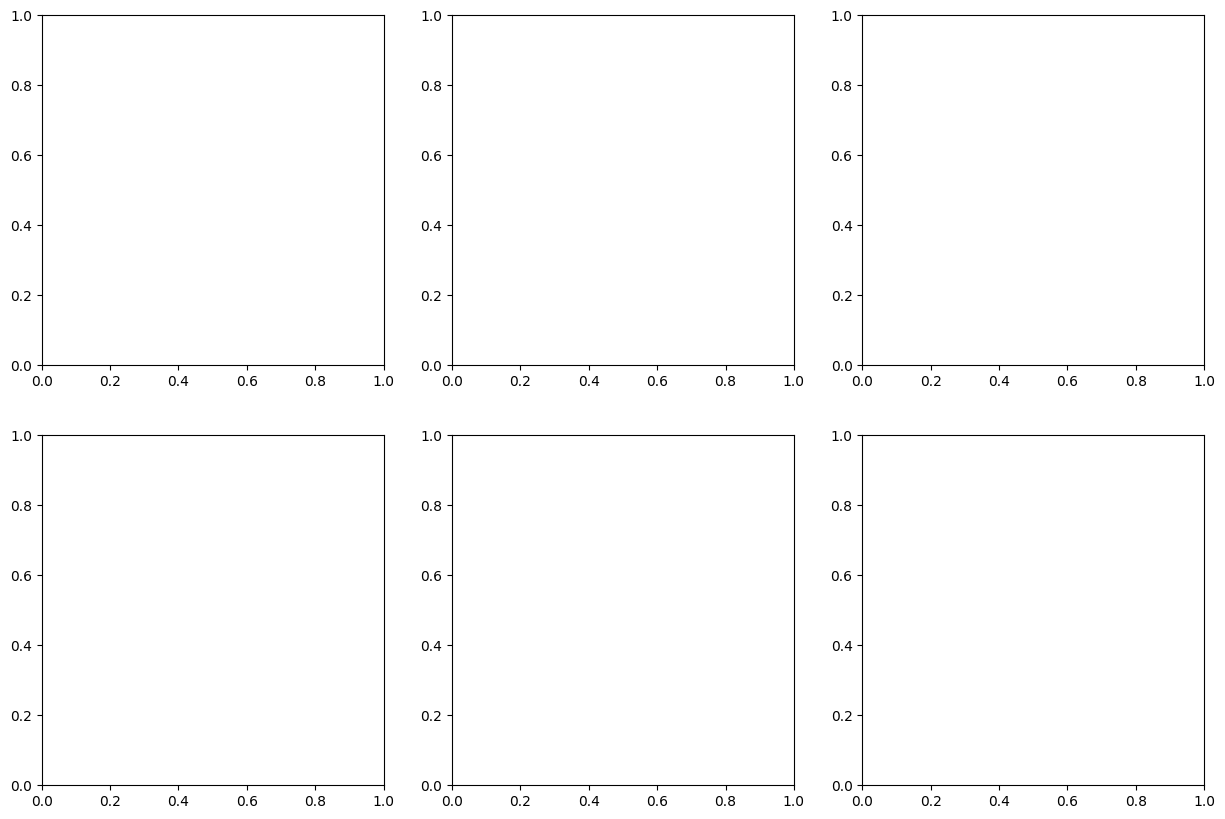

In [14]:
from botorch.models.gpytorch import GPyTorchModel
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming you have a trained BoTorch GP model named gp_model

# Define a helper function to fetch the device
def fetch_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming you want to highlight a specific point (s1, s2, action) on the plot
highlight_point = torch.tensor([0.5, 0.5, 0])  # Example highlight point

# Call the plot function
plot_gp_contours_with_uncertainty(gp_mixed_model, d_values=3, highlight_point=highlight_point, title='GP Contours')

# If you don't want to highlight any point, just omit the highlight_point argument:
# plot_gp_contours_with_uncertainty(gp_model, d_values=3, title='GP Contours')
